In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

import sys
sys.path.append('../lib/')
from blood_lib import import_pbc, learning_curves

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

2023-05-14 21:24:26.290802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.12.0'

In [3]:
path = '../Data/PBC_11cat_masked/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=1
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8, seed=1)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)

Found 16891 files belonging to 11 classes.
Using 13513 files for training.
Using 3378 files for validation.


2023-05-14 21:24:40.607914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13513]
	 [[{{node Placeholder/_4}}]]
2023-05-14 21:24:40.608299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13513]
	 [[{{node Placeholder/_0}}]]


train batch : 338
val batch : 106
test batch : 85
classes : ['BA', 'BNE', 'EO', 'ERB', 'LY', 'MMY', 'MO', 'MY', 'PLT', 'PMY', 'SNE']
num_classes : 11


Calcul des class_weights

On veut "accorder plus d'attention" aux exemples d'une classe sous-représentée

In [4]:
directory = Path(path)
class_weights = {}
total = len(list(directory.glob('**/*.png')))
for i, class_name in enumerate(class_names):
    #print(i, class_name)
    len_i = len(list(Path(directory/class_name).glob('*.png')))
    print(i, len_i)
    weight_for_i = (1 / len_i) * (total / num_classes)
    #print(weight_for_i)
    class_weights[i] = weight_for_i
class_weights

0 1218
1 1633
2 3117
3 1551
4 1214
5 1015
6 1420
7 1137
8 2348
9 592
10 1646


{0: 1.260710553814002,
 1: 0.9403217725324278,
 2: 0.4926356928281856,
 3: 0.9900357540589648,
 4: 1.2648644600868653,
 5: 1.5128526645768023,
 6: 1.081370038412292,
 7: 1.3505237067242344,
 8: 0.6539801765525786,
 9: 2.5938267813267815,
 10: 0.9328951728708714}

Remarque : L'utilisation de class_weights modifie la plage de perte. Cela peut affecter la stabilité de l'entraînement en fonction de l'optimiseur. Les optimiseurs dont la taille de pas dépend de l'ampleur du gradient, comme tf.keras.optimizers.SGD , peuvent échouer. L'optimiseur utilisé ici, tf.keras.optimizers.Adam , n'est pas affecté par le changement d'échelle. Notez également qu'en raison de la pondération, les pertes totales ne sont pas comparables entre les deux modèles.

In [5]:
# Random data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0,255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])

def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds

train_ds = process_images(train_ds, shuffle=100, augment=True)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)

2023-05-14 21:25:05.905648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10810,11]
	 [[{{node Placeholder/_1}}]]
2023-05-14 21:25:05.906114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype resource
	 [[{{node Placeholder/_14}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for int

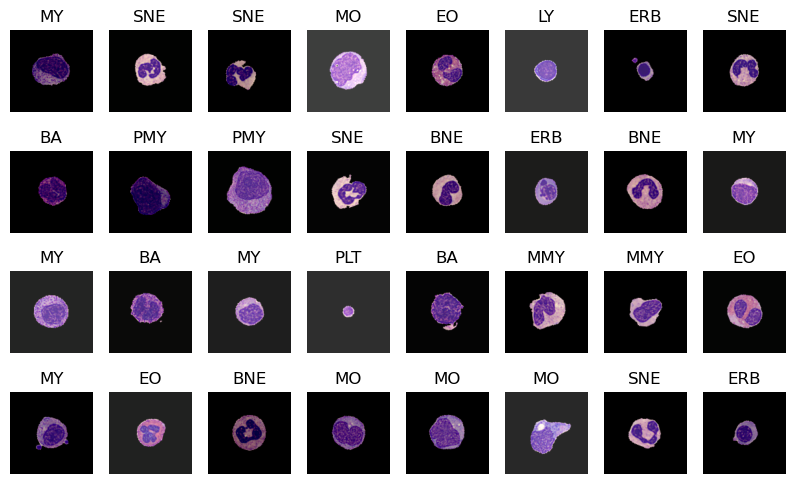

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,6))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(class_names[np.argmax(label_batch[i])])
  plt.axis("off")

In [14]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
# Freezer les couches du VGG16
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(2048,activation='relu'))
model.add(Dense(1028, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # model.add(Dense(11 +1, activation='softmax')) ??

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2048)              16779264  
                                                                 
 dense_1 (Dense)             (None, 1028)              2106372   
                                                                 
 dense_2 (Dense)             (None, 512)               526848    
                                                                 
 dense_3 (Dense)             (None, 11)                5643      
                                                                 
Total params: 34,132,815
Trainable params: 26,497,551


In [8]:
epochs=50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1)]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

2023-05-14 21:25:35.791985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype resource
	 [[{{node Placeholder/_16}}]]
2023-05-14 21:25:35.792457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype resource
	 [[{{node Placeholder/_15}}]]


Epoch 1/50
338/338 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.6630

2023-05-14 21:36:37.463654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3378]
	 [[{{node Placeholder/_4}}]]
2023-05-14 21:36:37.463949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3378]
	 [[{{node Placeholder/_4}}]]


338/338 [==============================] - 787s 2s/step - loss: 1.0719 - accuracy: 0.6630 - val_loss: 0.7856 - val_accuracy: 0.7262
Epoch 2/50
338/338 [==============================] - 664s 2s/step - loss: 0.6121 - accuracy: 0.8029 - val_loss: 0.5407 - val_accuracy: 0.8117
Epoch 3/50
338/338 [==============================] - 666s 2s/step - loss: 0.5320 - accuracy: 0.8325 - val_loss: 0.4485 - val_accuracy: 0.8336
Epoch 4/50
338/338 [==============================] - 679s 2s/step - loss: 0.4788 - accuracy: 0.8502 - val_loss: 0.4411 - val_accuracy: 0.8289
Epoch 5/50
338/338 [==============================] - 660s 2s/step - loss: 0.4468 - accuracy: 0.8549 - val_loss: 0.4313 - val_accuracy: 0.8401
Epoch 6/50
338/338 [==============================] - 663s 2s/step - loss: 0.4191 - accuracy: 0.8688 - val_loss: 0.3943 - val_accuracy: 0.8434
Epoch 7/50
338/338 [==============================] - 661s 2s/step - loss: 0.3981 - accuracy: 0.8662 - val_loss: 0.3693 - val_accuracy: 0.8600
Epoch 8/50

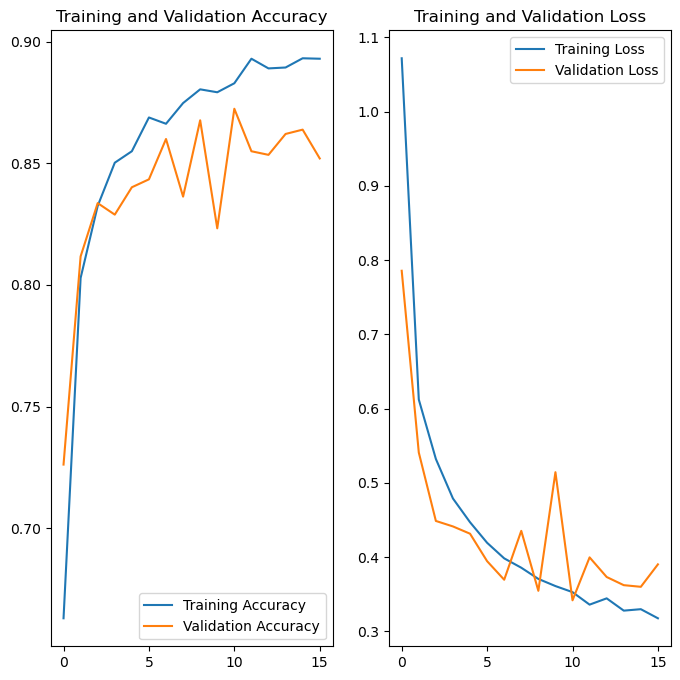

In [9]:
learning_curves(history)

In [10]:
model.save('../Models/VGG16_pt_11cat_4layers.h5')

In [11]:
VGG16 = tf.keras.models.load_model('../Models/VGG16_pt_11cat_4layers.h5')

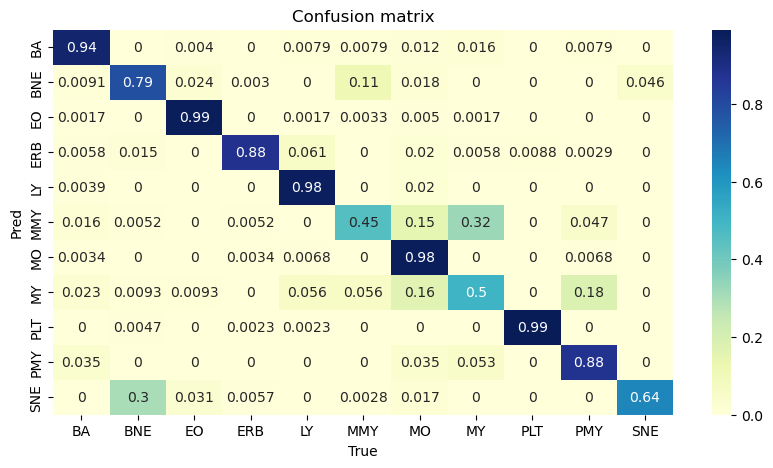

              precision    recall  f1-score   support

          BA       0.92      0.94      0.93       252
         BNE       0.69      0.79      0.74       329
          EO       0.96      0.99      0.98       605
         ERB       0.98      0.88      0.93       342
          LY       0.87      0.98      0.92       256
         MMY       0.62      0.45      0.52       192
          MO       0.75      0.98      0.85       293
          MY       0.59      0.50      0.54       214
         PLT       0.99      0.99      0.99       430
         PMY       0.65      0.88      0.75       113
         SNE       0.94      0.64      0.76       352

    accuracy                           0.85      3378
   macro avg       0.81      0.82      0.81      3378
weighted avg       0.86      0.85      0.85      3378



In [12]:
preds = VGG16.predict(
        val_ds,
        batch_size=32,
        verbose=0
)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in val_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

2023-05-15 07:21:57.828788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2703,11]
	 [[{{node Placeholder/_1}}]]


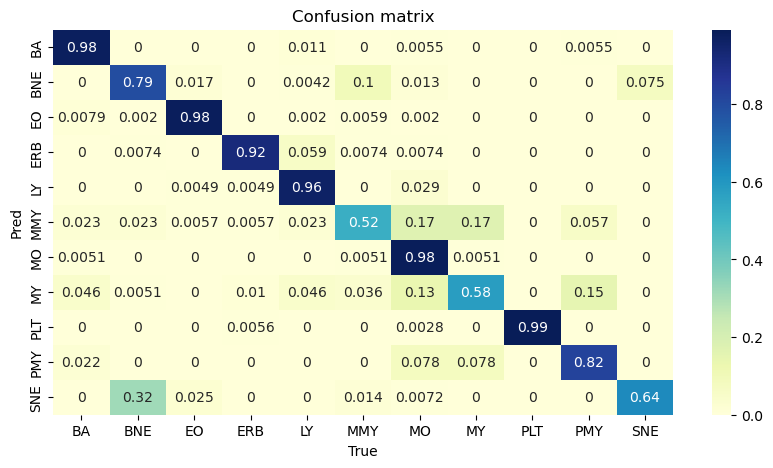

              precision    recall  f1-score   support

          BA       0.90      0.98      0.94       182
         BNE       0.66      0.79      0.72       240
          EO       0.97      0.98      0.98       508
         ERB       0.98      0.92      0.95       272
          LY       0.86      0.96      0.91       206
         MMY       0.69      0.52      0.60       176
          MO       0.71      0.98      0.82       196
          MY       0.75      0.58      0.65       197
         PLT       1.00      0.99      1.00       357
         PMY       0.65      0.82      0.73        90
         SNE       0.91      0.64      0.75       279

    accuracy                           0.86      2703
   macro avg       0.83      0.83      0.82      2703
weighted avg       0.86      0.86      0.85      2703



In [13]:
preds = VGG16.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")